<a href="https://colab.research.google.com/github/Kulikov17/MLDS_DL/blob/main/toxic_comments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Скачаем датасет из kaggle

In [2]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
! kaggle competitions download -c toxic-comments-classification-2023

  0% 0.00/1.52M [00:00<?, ?B/s]
100% 1.52M/1.52M [00:00<00:00, 158MB/s]


In [4]:
!unzip toxic-comments-classification-2023.zip

Archive:  toxic-comments-classification-2023.zip
  inflating: sample_submission.csv   
  inflating: test_data.csv           
  inflating: train_data.csv          


In [5]:
import pandas as pd
import numpy as np

#data visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import *

In [6]:
RANDOM_SEED = 42

In [7]:
train = pd.read_csv('train_data.csv')
test = pd.read_csv('test_data.csv')

In [8]:
train.sample(3)

,comment,toxic
4161,И еще ооочень важный момент! Трисс накладывать...,0.0
4094,дешевую звуковую карту А че за карта у него? О...,0.0
2737,"Судя по новостям, суды настолько скомпроментир...",0.0


In [7]:
test.sample()

,comment_id,comment
430,430,"Алеша Лобстер, иди нахуй.\n"


Проверим, сбалансированы ли данные

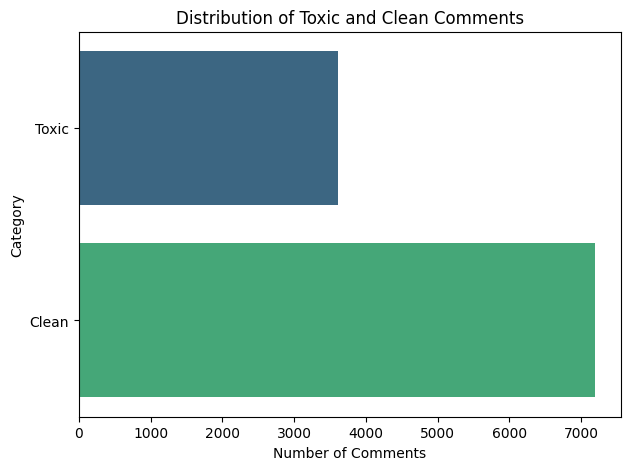

In [9]:
train_toxic = train[train['toxic'] == 1]
train_clean = train[train['toxic'] == 0]

num_toxic = len(train_toxic)
num_clean = len(train_clean)

plot_data = pd.DataFrame(
    {'Category': ['Toxic', 'Clean'], 'Count': [num_toxic, num_clean]})

plt.figure(figsize=(7, 5))

ax = sns.barplot(x='Count', y='Category', data=plot_data, palette='viridis')

plt.xlabel('Number of Comments')
plt.ylabel('Category')
plt.title('Distribution of Toxic and Clean Comments')

plt.show()

Мы можем заметить, что наш набор данных сильно несбалансирован.

In [26]:
print(train_toxic.shape)
print(train_clean.shape)

(3608, 2)
(7201, 2)


Чтобы справиться с несбалансированными данными, мы можем создать новый обучающий набор, в котором количество токсичных комментариев останется прежним, и для соответствия этому мы случайным образом выберем 3608 чистых комментариев и включим их в обучающий набор.

In [10]:
train_clean_sampled = train_clean.sample(n=3608, random_state=RANDOM_SEED)

train_balanced = pd.concat([train_toxic, train_clean_sampled], axis=0)

# Перетасуем данные, чтобы избежать смещения порядка во время обучения.
train_balanced = train_balanced.sample(frac=1, random_state=RANDOM_SEED)

Для обучения модели разобьем train выборку на x_train и x_test:

In [11]:
x_train, x_test = train_test_split(train_balanced, test_size=0.2)

Попробуем реализовать подход с BERT. В интернете я почитал следующие статьи:

1. https://habr.com/ru/articles/562064/ - про BERT для русского языка (модель rubert-tiny).
2. https://huggingface.co/cointegrated/rubert-tiny2 - Автор из статьи 1 позднее выложил модель rubert-tiny2 на huggingFace, она является более полной. В обучении использовал именно ее.
3. Также ниже я использовал удобную обертку BERT для классификации русскоязычных текстов https://github.com/shitkov/bert4classification Также автор репозитория написал статью https://habr.com/ru/articles/567028/  Решение является очень удобным, досточно просто передать предобученную модель, которую хотим использовать

In [12]:
!wget https://raw.githubusercontent.com/shitkov/bert4classification/main/bert_classifier.py
!wget https://raw.githubusercontent.com/shitkov/bert4classification/main/bert_dataset.py

--2023-11-25 21:11:12--  https://raw.githubusercontent.com/shitkov/bert4classification/main/bert_classifier.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5278 (5.2K) [text/plain]
Saving to: ‘bert_classifier.py’

bert_classifier.py  100%[===================>]   5.15K  --.-KB/s    in 0s      

2023-11-25 21:11:12 (52.9 MB/s) - ‘bert_classifier.py’ saved [5278/5278]

--2023-11-25 21:11:12--  https://raw.githubusercontent.com/shitkov/bert4classification/main/bert_dataset.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 891 [tex

In [21]:
from bert_dataset import CustomDataset
from bert_classifier import BertClassifier

In [24]:
classifier = BertClassifier(
        model_path='cointegrated/rubert-tiny2',
        tokenizer_path='cointegrated/rubert-tiny2',
        n_classes=2,
        epochs=5,
        model_save_path='rubert-tiny2.pt'
)

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/118M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.74M [00:00<?, ?B/s]

In [25]:
classifier.preparation(
        X_train=list(x_train['comment']),
        y_train=list(x_train['toxic']),
        X_valid=list(x_test['comment']),
        y_valid=list(x_test['toxic'])
    )

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [26]:
classifier.train()

Epoch 1/5
Train loss 0.45195778953375787 accuracy 0.8846153846153846
Val loss 0.39644976103226226 accuracy 0.9148199445983379
----------
Epoch 2/5
Train loss 0.2993231423516273 accuracy 0.9364171864171864
Val loss 0.3954717047400308 accuracy 0.9168975069252078
----------
Epoch 3/5
Train loss 0.21510437892603318 accuracy 0.9568607068607069
Val loss 0.5181651863596342 accuracy 0.907202216066482
----------
Epoch 4/5
Train loss 0.16276662939279488 accuracy 0.967948717948718
Val loss 0.5118809641390724 accuracy 0.9134349030470914
----------
Epoch 5/5
Train loss 0.14208730650226356 accuracy 0.9745322245322245
Val loss 0.5451483735468831 accuracy 0.9106648199445984
----------


Сохраняем результат для Kaggle

In [54]:
comment_ids = []
comments = []

for _, row in test.iterrows():
  comment_ids.append(row['comment_id'])
  comments.append(classifier.predict(row['comment']))

In [55]:
df = pd.DataFrame({'comment_id': comment_ids, 'toxic': comments}).sort_values(by=['comment_id'])

In [61]:
with open('toxic_data.csv', 'w') as csv_file:
  df.to_csv(path_or_buf=csv_file, index=False, header=['comment_id', 'toxic'], columns=['comment_id', 'toxic'])

Этим решением на kaggle был выбит скор 0.91590